In [1]:
import SIRD_Model

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [2]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

In [81]:
from scipy.optimize import minimize


#note paramArg is in the format of [q, beta, gamma, nu]
def errorSIRD(paramArg, pop, I, R, D): #the custom error function for SIRD
    lamda = 10
    w = .9
    q = paramArg[0]
    b = paramArg[1:5]
    params = paramArg[4:] #beta3, gamma, nu
    params[0] = paramArg[1] #beta0, gamma, nu
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    #use b0 in the place of b0, and multiply first column by 1/(1+(I*b1+D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D
    
    y, A = SIRD_Model.getSIRDMatrices(S, I, R, D)
    
    #transform location where beta is needed and multiply by 1/(1+(I*b1+D*b2)^b3)
    #A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    #A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    print(b, params)
    A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    
    totalError = 0
    #see paper for optimization function
    T = len(A)
    for t in range(T):
        totalError = totalError + (w**(T - t))*(np.linalg.norm((A[t] @ params) - y[t].transpose(), ord=2)**2)
    
    #return (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    totalError = (1.0/T)*totalError #divide by timeframe
    totalError = totalError + lamda*np.linalg.norm(params, ord=1) #regularization error
    print(totalError)
    return totalError
    

pop = 60000000
numDays = 30 #len(infectRaw) #max days
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]

defaultParams=[.1, 1,0,0,1 , .1, .1] #default guesses, q, beta0,beta1,beta2,beta3, gamma, nu

result = minimize(errorSIRD, defaultParams, args=(pop, infect, recov, dead),
                  method='BFGS', options={'maxiter': 5000})

q=result.x[0]
params=result.x[1:]
print(q, params)

[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.  0.1 0.1]
358403338.0272858
[1.00000001 0.         0.         1.00000001] [1.00000001 0.1        0.1       ]
358403350.4430361
[1.00000000e+00 1.49011612e-08 0.00000000e+00 1.00000000e+00] [1.  0.1 0.1]
357852636.9973632
[1.00000000e+00 0.00000000e+00 1.49011612e-08 1.00000000e+00] [1.  0.1 0.1]
358340608.80554694
[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.         0.10000001 0.1       ]
358403331.8053434
[1. 0. 0. 1.] [1.         0.1        0.10000001]
358403331.8275984
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52769893
[0.9999757  1.00351086 0.11430636 0.9999757 ] [0.9999757  0.10000964 0.1000096 ]
36138057.52869678
[0.99997568 1.00351088 0.11430636 0.999975

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


[-13130.62454551    -86.25226671    754.75324475 -13130.62454551] [-13130.62454551  12960.87157172 -12893.45965482]
nan
[-13130.62454551    -86.25226671    754.75324473 -13130.62454551] [-13130.62454551  12960.87157172 -12893.45965482]
nan
[-13130.62454551    -86.25226671    754.75324473 -13130.62454551] [-13130.62454551  12960.87157173 -12893.45965482]
nan
[-13130.62454551    -86.25226671    754.75324473 -13130.62454551] [-13130.62454551  12960.87157172 -12893.45965481]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535      -345.37359263   3021.21353196 -52564.00535   ] [-52564.00535     51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359261   3021.

[-5.51318623e+10 -3.62277871e+08  3.16874120e+09 -5.51318623e+10] [-5.51318623e+10  5.44150889e+10 -5.41318352e+10]
nan
[-5.51318623e+10 -3.62277871e+08  3.16874115e+09 -5.51318623e+10] [-5.51318623e+10  5.44150889e+10 -5.41318352e+10]
nan
[-5.51318623e+10 -3.62277871e+08  3.16874115e+09 -5.51318623e+10] [-5.51318623e+10  5.44150897e+10 -5.41318352e+10]
nan
[-5.51318623e+10 -3.62277871e+08  3.16874115e+09 -5.51318623e+10] [-5.51318623e+10  5.44150889e+10 -5.41318360e+10]
nan
[-2.20527449e+11 -1.44911148e+09  1.26749646e+10 -2.20527449e+11] [-2.20527449e+11  2.17660356e+11 -2.16527341e+11]
nan
[-2.20527449e+11 -1.44911148e+09  1.26749646e+10 -2.20527449e+11] [-2.20527449e+11  2.17660356e+11 -2.16527341e+11]
nan
[-2.20527449e+11 -1.44911148e+09  1.26749646e+10 -2.20527449e+11] [-2.20527449e+11  2.17660356e+11 -2.16527341e+11]
nan
[-2.20527452e+11 -1.44911148e+09  1.26749646e+10 -2.20527452e+11] [-2.20527452e+11  2.17660356e+11 -2.16527341e+11]
nan
[-2.20527449e+11 -1.44911151e+09  1.2674

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


nan
[-37.50982526  -0.21588896   2.21760249 -37.50982526] [-37.50982526  37.98139723 -37.83860997]
nan
[-37.50982526  -0.21588896   2.21760249 -37.50982526] [-37.50982526  37.98139722 -37.83860996]
nan
[-76.01898621  -0.46893713   4.43094262 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893713   4.43094262 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893713   4.43094262 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898619  -0.46893713   4.43094262 -76.01898619] [-76.01898619  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893711   4.43094262 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893713   4.43094263 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893713   4.43094262 -76.01898621] [-76.01898621  75.98989773 -75.64926011]
nan
[-76.01898621  -0.46893713   4.43094262 -76.01898621] [-76.01898621  75.98989775 -75.64926011]
nan
[-76.0

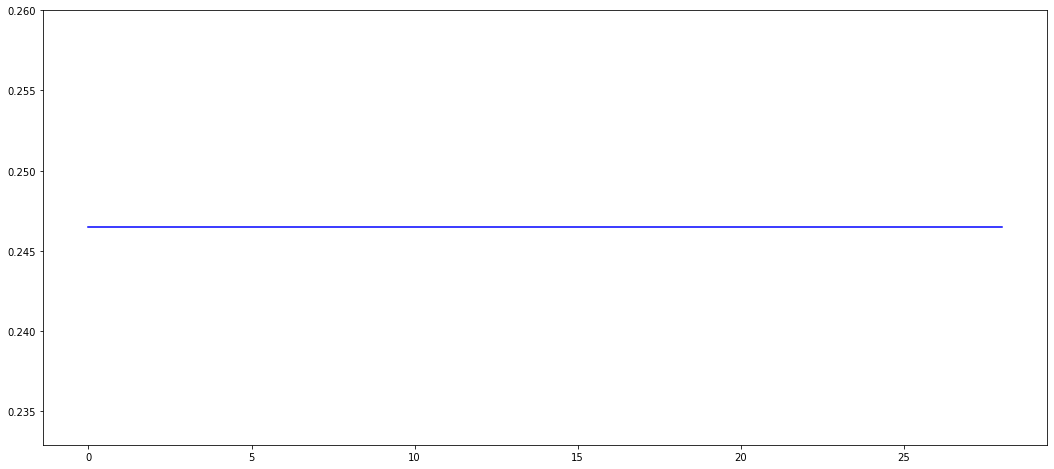

In [75]:
bT = params[0] / (1 + (infect[0:-1]*params[1] + dead[0:-1]*params[2])**params[3])
#print(bT)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(bT, color='blue', label='beta')

In [80]:
defaultParams=[.1, 1,0,0,1 , .1, .1] #default guesses, q, beta0,beta1,beta2,beta3, gamma, nu

result = minimize(errorSIRD, defaultParams, args=(pop, infect, recov, dead),
                  method='BFGS', options={'maxiter': 5000})

[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.  0.1 0.1]
358403338.0272858
[1.00000001 0.         0.         1.00000001] [1.00000001 0.1        0.1       ]
358403350.4430361
[1.00000000e+00 1.49011612e-08 0.00000000e+00 1.00000000e+00] [1.  0.1 0.1]
357852636.9973632
[1.00000000e+00 0.00000000e+00 1.49011612e-08 1.00000000e+00] [1.  0.1 0.1]
358340608.80554694
[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.         0.10000001 0.1       ]
358403331.8053434
[1. 0. 0. 1.] [1.         0.1        0.10000001]
358403331.8275984
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52769893
[0.9999757  1.00351086 0.11430636 0.9999757 ] [0.9999757  0.10000964 0.1000096 ]
36138057.52869678
[0.99997568 1.00351088 0.11430636 0.999975

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535      -345.37359263   3021.21353196 -52564.00535   ] [-52564.00535     51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359261   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353197 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609728 -51611.56538989]
nan
[-52564.00535002   -345.37359263   3021.21353196 -52564.00535002] [-52564.00535002  51881.57609726 -51611.56538988]
nan
[-210297.52856804   -1381.85889632   120

nan
[-3.52843919e+12 -2.31857838e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843924e+12 -2.31857838e+10  2.02799434e+11 -3.52843924e+12] [-3.52843924e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857841e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.02799437e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256569e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.02799434e+11 -3.52843919e+12] [-3.52843919e+12  3.48256574e+12 -3.46443746e+12]
nan
[-3.52843919e+12 -2.31857838e+10  2.

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


nan
[-307.07395186   -1.98722615   17.71098336 -307.07395186] [-307.07395186  304.04090081 -302.5131609 ]
nan
[-307.07395184   -1.98722615   17.71098336 -307.07395184] [-307.07395184  304.04090081 -302.5131609 ]
nan
[-307.07395186   -1.98722613   17.71098336 -307.07395186] [-307.07395186  304.04090081 -302.5131609 ]
nan
[-307.07395186   -1.98722615   17.71098338 -307.07395186] [-307.07395186  304.04090081 -302.5131609 ]
nan
[-307.07395186   -1.98722615   17.71098336 -307.07395186] [-307.07395186  304.04090081 -302.5131609 ]
nan
[-307.07395186   -1.98722615   17.71098336 -307.07395186] [-307.07395186  304.04090083 -302.5131609 ]
nan
[-307.07395186   -1.98722615   17.71098336 -307.07395186] [-307.07395186  304.04090081 -302.51316088]
nan
[-615.14723939   -4.01161151   35.41770436 -615.14723939] [-615.14723939  608.10890492 -604.99836195]
nan
[-615.14723939   -4.01161151   35.41770436 -615.14723939] [-615.14723939  608.10890492 -604.99836195]
nan
[-615.14723939   -4.01161151   35.41770436